<a href="https://colab.research.google.com/github/Larissa-Jackie/Python-Project/blob/main/US_Data_Job_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Data Job Analysis Project

##Goal

### 1. Investigate top-paying roles and skills in the data science industry.
### 2. Use Python to explore a real life dataset on job posting.
### 3. For job-seekers: use these insights to help find the best job opportunities.

# EDA

In [ ]:
!pip install datasets

In [4]:
# import libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

In [5]:
# load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/785741 [00:00<?, ? examples/s]

In [10]:
# data cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [11]:
# filter data to jobs in the US and job title is Data Analyst
df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')]

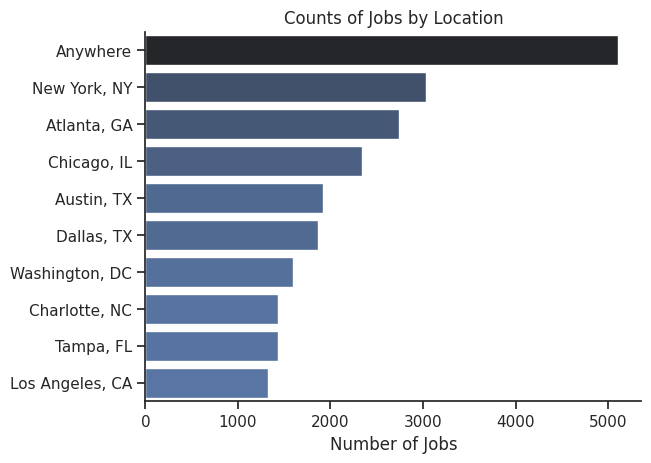

In [12]:
# plot top 10 job locations with the count
df_location_plot = df_DA_US['job_location'].value_counts().head(10).to_frame()

sns.set_theme(style='ticks')
sns.barplot(data=df_location_plot, x='count', y='job_location', hue='count',
            palette='dark:b_r', legend=False)
sns.despine() # remove boarder
plt.title('Counts of Jobs by Location')
plt.xlabel('Number of Jobs')
plt.ylabel('')
plt.show()

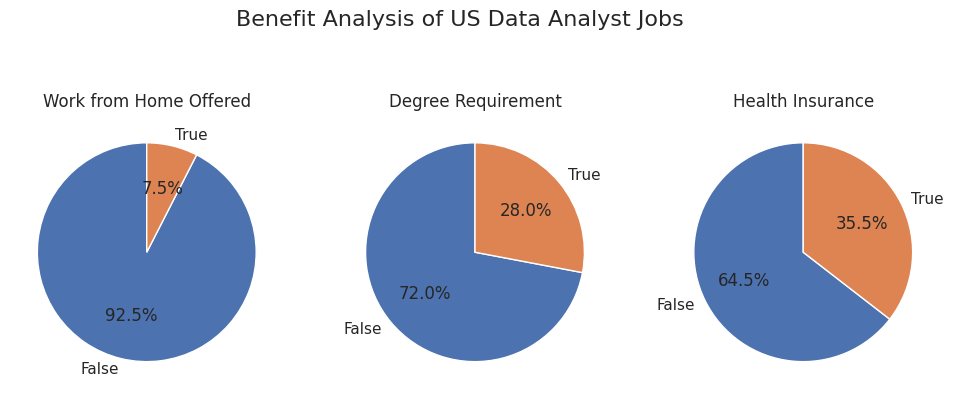

In [13]:
# plot percentages for WFH/Degree Required/Offer Health Insurance
dict_column = {
    'job_work_from_home': 'Work from Home Offered',
    'job_no_degree_mention': 'Degree Requirement',
    'job_health_insurance': 'Health Insurance'
}

fig, ax = plt.subplots(1, 3)
fig.set_size_inches((12, 5))

for i, (column, title) in enumerate(dict_column.items()):
  ax[i].pie(df_DA_US[column].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
  ax[i].set_title(title)

plt.suptitle('Benefit Analysis of US Data Analyst Jobs', fontsize=16)
plt.show()

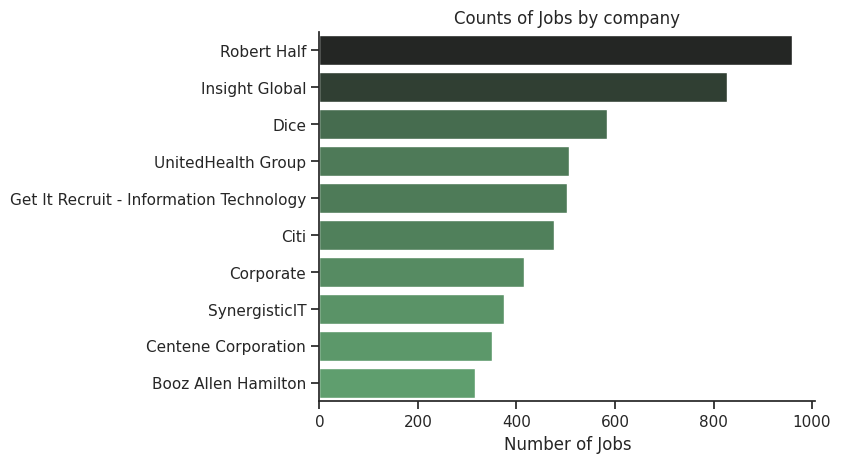

In [14]:
# plot top 10 companies with the count
df_location_plot = df_DA_US['company_name'].value_counts().head(10).to_frame()

sns.set_theme(style='ticks')
sns.barplot(data=df_location_plot, x='count', y='company_name', hue='count',
            palette='dark:g_r', legend=False)
sns.despine() # remove boarder
plt.title('Counts of Jobs by company')
plt.xlabel('Number of Jobs')
plt.ylabel('')
plt.show()

# What are the most demanded skills for the top 3 most popular data roles?

In [15]:
# US records only
df_US = df[df['job_country'] == 'United States']

In [16]:
# count skills

df_skills = df_US.explode('job_skills')
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size().reset_index(
    name='skill_count')
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

In [17]:
# top 3 job titles by count
job_titles = df_skills_count['job_title_short'].unique().tolist()[:3]
job_titles

['Data Scientist', 'Data Analyst', 'Data Engineer']

In [18]:
# calculate likelihood of skills in job postings

df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')
df_skills_perc['skill_percent'] = df_skills_perc['skill_count']/df_skills_perc['jobs_total'] * 100

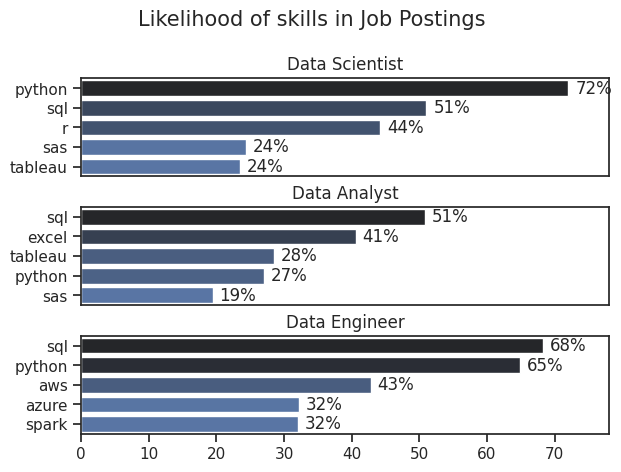

In [19]:
# plot likelihood for top 5 skills in top 3 job titles

fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
  df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
  sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i],
              hue='skill_count', palette='dark:b_r')
  ax[i].set_title(job_title)
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].legend().set_visible(False)
  ax[i].set_xlim(0, 78)

  for n, value in enumerate(df_plot['skill_percent']):
    ax[i].text(value + 1, n, f'{value:.0f}%', va='center') # value+1 adjust the x position give padding

  if i != len(job_titles) - 1:
    ax[i].set_xticks([])

fig.suptitle('Likelihood of skills in Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()

The top 3 most popular roles are Data Sicentist, Data Analyst, and Data Engineer.\
-- Under these 3 roles, Pythoon is most prominently for Data Scientists (72%) and Data Engineer(65%).
SQL is highly demanded skill accross all three roles.\
--Data Enginner requires more specialized technical skills (AWS, Azure, Spark) compared to Data Analysts and Data Scientists.\
--Data Analyst requires more generic tools such as excel.

# How are in_demand skills trending for Data Analysts in the USA?

In [ ]:
# for US Data Analyst job data, expand job_skills to seperate rows, also add month column
df_DA_US['job_posted_month'] = df_DA_US['job_posted_date'].dt.month
df_DA_US_explode = df_DA_US.explode('job_skills')

In [21]:
# pivot
df_DA_US_pivot = df_DA_US_explode.pivot_table(index='job_posted_month',
                                              columns='job_skills', aggfunc='size', fill_value=0)

# add Total row
df_DA_US_pivot.loc['total'] = df_DA_US_pivot.sum()

# sort data by Total decending
df_DA_US_pivot = df_DA_US_pivot[df_DA_US_pivot.loc['total'].sort_values(ascending=False).index]
df_DA_US_pivot= df_DA_US_pivot.drop('total')

# percentage of each skill for job posted each month
DA_totals = df_DA_US.groupby('job_posted_month').size()
df_DA_US_perc = df_DA_US_pivot.div(DA_totals/100, axis=0)

# top 5 skills
df_DA_US_plot = df_DA_US_perc.iloc[:,:5]
df_DA_US_plot

job_skills,sql,excel,tableau,python,sas
job_posted_month,,,,,
1,54.167648,42.288674,29.291264,26.536379,21.568166
2,51.730895,42.243632,27.367734,26.420640,19.790986
3,51.881634,42.795111,29.012544,27.066581,19.909939
4,53.231939,42.139197,29.575136,27.756654,21.524219
5,51.692369,42.419387,28.680152,27.017825,19.467254
6,50.360725,41.914482,28.646841,28.312511,17.314799
7,50.163430,40.722938,29.475101,27.648529,19.150163
8,51.462165,41.166717,29.409105,30.524570,19.234248
9,49.471869,38.823022,29.165768,26.492779,18.452253


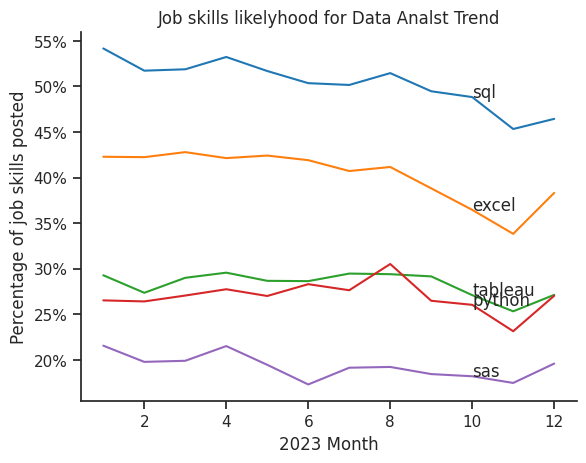

In [22]:
# plot
sns.lineplot(data=df_DA_US_plot, dashes=False, palette='tab10')
sns.despine()

plt.title('Job skills likelyhood for Data Analst Trend')
plt.xlabel('2023 Month')
plt.ylabel('Percentage of job skills posted')
plt.legend().remove()

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

for i in range(5):
  plt.text(10, df_DA_US_plot.iloc[-3,i], df_DA_US_plot.columns[i])

SQL is the most demanded skill for Data Analyst through out 2023, followed by Excel. Python and Tableau are relatively at the same level of skill posted.

# How well do jobs and skills pay for Data Analyst?

In [23]:
# fetch top 6 roles by count and its salary in the US
df_US_full = df_US.dropna(subset=['salary_year_avg'])
job_titles = df_US_full['job_title_short'].value_counts().index[:6].tolist()
df_US_top6 = df_US_full[df_US_full['job_title_short'].isin(job_titles)]

# extract roles with the order of their median salary descending
job_order = df_US_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index

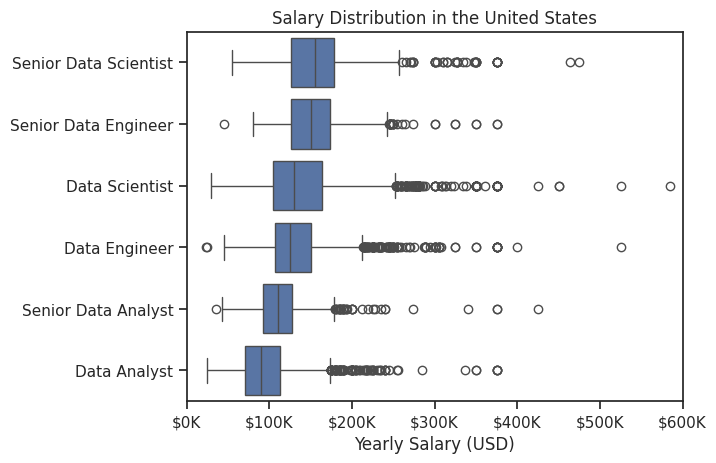

In [24]:
# plot
sns.boxplot(data=df_US_top6, x='salary_year_avg', y='job_title_short', order=job_order)

plt.title('Salary Distribution in the United States')
plt.xlabel('Yearly Salary (USD)')
plt.ylabel('')
plt.xlim(0, 600000)
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

Data Scientist and Senior Data Scientist roles show a considerable number of outliers on the higher end of the salary spectrum, suggesting that exceptional skills or circumstance can lead to high pay.\
In contrast, Data Analyst roles demonstrate more consistency in salary, with fewer outliers and least average pay compared to other roles.\
Overall, Senior roles pay slightly more.

# Which Data Analyst skill have the most median salary?

In [25]:
# fetch US Data Analyst skill and removed NA value
df_DA_US_full = df[(df['job_country']=='United States') &
 (df['job_title_short']=='Data Analyst')].dropna(subset=['salary_year_avg'])

In [26]:
df_skill_exploded = df_DA_US_full.explode('job_skills')

# top 10 highest median salary and the corresponding skill for DA
df_DA_toppay = (df_skill_exploded.groupby('job_skills')['salary_year_avg'].
                agg(['count','median']).sort_values('median', ascending=False))
df_DA_toppay = df_DA_toppay.head(10)


# top 10 most demanding skills and its median salary, sorted by its median salary
df_DA_topskill = (df_skill_exploded.groupby('job_skills')['salary_year_avg'].
                agg(['count','median']).sort_values('count', ascending=False))
df_DA_topskill = df_DA_topskill.head(10).sort_values(by='median', ascending=False)

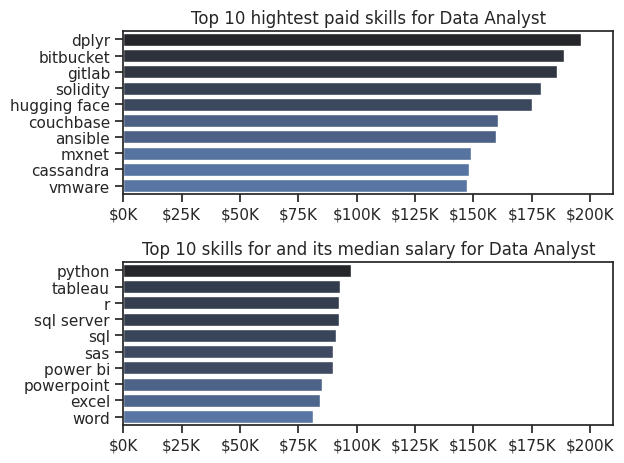

In [27]:
# plot
fig, ax = plt.subplots(2,1)

#plot top 10 highest pay
sns.barplot(data=df_DA_toppay, x='median',
            y=df_DA_toppay.index, hue='median', ax=ax[0], palette='dark:b_r')
ax[0].legend().remove()
ax[0].set_title("Top 10 hightest paid skills for Data Analyst")
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax[0].set_xlim(0, 210000)


#plot top 10 demanding skills
sns.barplot(data=df_DA_topskill, x='median',
            y=df_DA_topskill.index, hue='median', ax=ax[1], palette='dark:b_r')
ax[1].legend().remove()
ax[1].set_title("Top 10 skills for and its median salary for Data Analyst")
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax[1].set_xlim(0, 210000)

sns
plt.tight_layout()
plt.show()

Most popular skills are not the highest paid skills.\
Among the most demanding skills, Python comes with the most salary.\
In order to get paid the most for Data Analyst role, more advanced skills such as dplyr, bitbucket, gitlab. However, the demand for these skills are very few.


# Which skills are the most optimal to acquire for Data Analyst in the US?

In [35]:
df_DA_topskill['skill_perc'] = df_DA_topskill['count'] / len(df_DA_US_full) * 100
df_DA_topskill.sort_values('count', ascending=False, inplace=True)
df_DA_skill_top5 = df_DA_topskill[df_DA_topskill['skill_perc']>5]
df_DA_skill_top5

,count,median,skill_perc
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


In [39]:
# set up which technology each skill belongs to
# categorize each skill to its group
df_tech = df['job_type_skills'].copy()
df_tech = df_tech.drop_duplicates()
df_tech = df_tech.dropna()

# combine all dictionary into one
tech_dict={}
for row in df_tech:
  row_dict = ast.literal_eval(row)
  for key, value in row_dict.items():
    if key in tech_dict:
      tech_dict[key] += value
    else:
      tech_dict[key] = value

# remove dups by converting values to set then back to list
for key, value in tech_dict.items():
  tech_dict[key] = list(set(value))

# converting it to dateframe
df_technology = pd.DataFrame(list(tech_dict.items()), columns=['technology', 'skill'])

df_technology = df_technology.explode('skill')
df_DA_skill_top5_plot = df_DA_skill_top5.merge(df_technology, left_on='job_skills', right_on='skill')

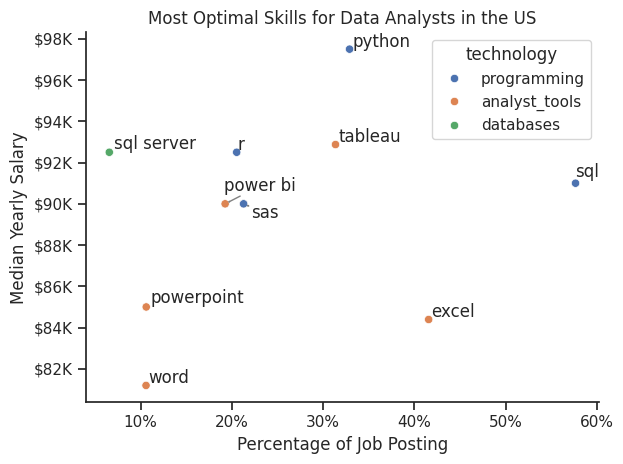

In [40]:
# plot scatter plot

df_DA_skill_top5
#!pip install adjustText
from adjustText import adjust_text

sns.scatterplot(
    data=df_DA_skill_top5_plot,
    x='skill_perc',
    y='median',
    hue='technology'
)
sns.despine()

texts = []
for i, txt in enumerate(df_DA_skill_top5.index):
  texts.append(plt.text(df_DA_skill_top5['skill_perc'].iloc[i],
                        df_DA_skill_top5['median'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel('Percentage of Job Posting')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()

According to the scatter plot, Python is the most optimal skill for Data Analyst role in the US.